In [23]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dummy Classifier
from sklearn.dummy import DummyClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# XGBoost
from xgboost import XGBClassifier

# multilayer perceptron
from sklearn.neural_network import MLPClassifier

# model explanation
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# for warning ignore
import warnings
warnings.filterwarnings("ignore")

### Importing the data

In [4]:
# setting the raw path
processed_data_path = os.path.join(os.path.pardir,"data","processed")
train_file_path = os.path.join(processed_data_path,"train.csv")
test_file_path = os.path.join(processed_data_path,"test.csv")

In [5]:
X = pd.read_csv(train_file_path)
y = pd.read_csv(test_file_path)

In [6]:
X.shape

(73096, 10)

In [7]:
y.shape

(73096, 1)

### Splitting the data

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=0)

In [9]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (65786, 10)
Number transactions y_train dataset:  (65786, 1)
Number transactions X_test dataset:  (7310, 10)
Number transactions y_test dataset:  (7310, 1)


### Dummy model
### Creating a dummy classifier
A dummy classifier is a type of classifier which does not generate any insight about the data and classifies the given data using only simple rules. The classifier’s behavior is completely independent of the training data as the trends in the training data are completely ignored and instead uses one of the strategies to predict the class label.
It is used only as a simple baseline for the other classifiers i.e. any other classifier is expected to perform better on the given dataset. It is especially useful for datasets where are sure of a class imbalance. It is based on the philosophy that any analytic approach for a classification problem should be better than a random guessing approach.

In [ ]:
'''
Below are a few strategies used by the dummy classifier to predict a class label –

Most Frequent: The classifier always predicts the most frequent class label in the training data.
Stratified: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.
Uniform: It generates predictions uniformly at random.

'''
strategies = ['most_frequent', 'stratified', 'uniform'] 
  
test_scores = [] 
for s in strategies: 
    #if s =='constant': 
       # dclf = DummyClassifier(strategy = s, random_state = 0) 
    #else: 
    dclf = DummyClassifier(strategy = s, random_state = 0) 
    dclf.fit(X_train, y_train) 
    score = dclf.score(X_test, y_test) 
    test_scores.append(score) 

In [ ]:
test_scores

[0.4807113543091655, 0.4987688098495212, 0.5175102599179207]

In [ ]:
# accuracy score
print('accuracy for baseline model : {0:.2f}'.format(accuracy_score(y_test, dclf.predict(X_test))))

accuracy for baseline model : 0.52


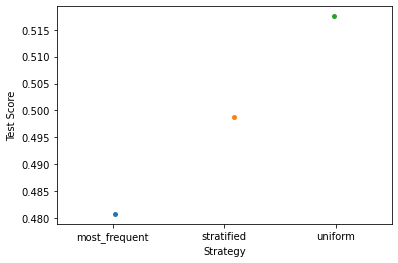

In [ ]:
ax = sns.stripplot(strategies, test_scores); 
ax.set(xlabel ='Strategy', ylabel ='Test Score') 
plt.show()

## Machine learning models

#### Defining the helper function for k-fold and stratified k-fold cross validation

In [10]:
# Defining the path to save the figures/plots.
figures_data_path = os.path.join(os.path.pardir, 'reports','figures')

In [11]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 4)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)

def model_classifier(model, X, y, cv):
    """
    Creates folds manually, perform 
    Returns an array of validation (recall) scores
    """
    scores = []
    
    
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        y_pred_prob = model_obj.predict_proba(X_test)[:,1]
        # Score the model on the validation data
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        scores.append(score)
        mean_score = np.array(scores).mean()    

    print('Accuracy scores of the model: {:.2f}'.format(mean_score))
    print('\n Classification report of the model')
    print('--------------------------------------')
    print(report)
    
    print('\n Confusion Matrix of the model')
    print('--------------------------------------')
    print(conf_matrix)
    
    print("\n ROC Curve")
    
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    val_model = input("Enter your model name: ")
    plt.plot(fpr, tpr, label= val_model + ' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    my_fig = val_model + '.png'
    plt.savefig(os.path.join(figures_data_path, my_fig))
    plt.show()

### Logistic regression model



In [12]:
# instantiating the model;
logregression = LogisticRegression()

#### 1. Using k-fold.
Overview:
The k-fold cross-validation procedure involves splitting the training dataset into k folds. The first k-1 folds are used to train a model, and the holdout kth fold is used as the test set. This process is repeated and each of the folds is given an opportunity to be used as the holdout test set. A total of k models are fit and evaluated, and the performance of the model is calculated as the mean of these runs.

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3636
           1       0.75      0.67      0.71      3673

    accuracy                           0.73      7309
   macro avg       0.73      0.73      0.72      7309
weighted avg       0.73      0.73      0.72      7309


 Confusion Matrix of the model
--------------------------------------
[[2825  811]
 [1195 2478]]

 ROC Curve


Enter your model name:  Logistic_regression_kf


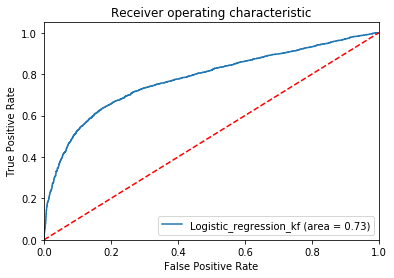

In [13]:
model_classifier(logregression, X, y,kf)

## 2. Stratified k-fold validation
Overview; This is the modified k-fold cross-validation and train-test splits can be used to preserve the class distribution in the dataset.

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3654
           1       0.76      0.68      0.72      3655

    accuracy                           0.73      7309
   macro avg       0.74      0.73      0.73      7309
weighted avg       0.74      0.73      0.73      7309


 Confusion Matrix of the model
--------------------------------------
[[2873  781]
 [1172 2483]]

 ROC Curve


Enter your model name:  Logistic_regression_skf


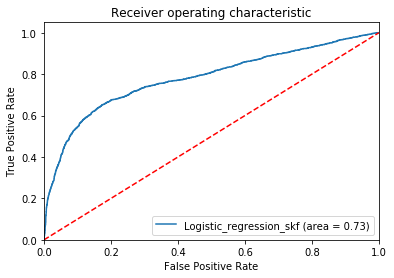

In [14]:
model_classifier(logregression, X, y,skf)

Hyperparameter Optimization:logistic regression

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3654
           1       0.76      0.68      0.72      3655

    accuracy                           0.73      7309
   macro avg       0.74      0.73      0.73      7309
weighted avg       0.74      0.73      0.73      7309


 Confusion Matrix of the model
--------------------------------------
[[2873  781]
 [1172 2483]]

 ROC Curve
Enter your model name: log_reg_cv


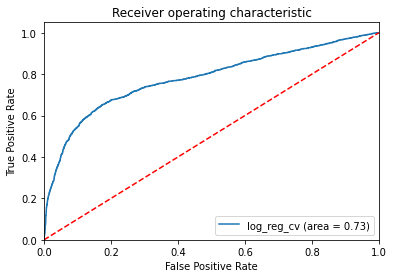

In [68]:
lr_hyp = LogisticRegression()

# regularization penalty space
penalty = ['l1', 'l2']

# regularization hyperparameter space
C = np.logspace(0, 4, 10)

# hyperparameter options
param_grid = dict(C=C, penalty=penalty)

log_reg_cv = GridSearchCV(lr_hyp, param_grid, verbose=0)

model_classifier(log_reg_cv, X, y, skf)

'''
lr_hyp = LogisticRegression()

# regularization penalty space
penalty = ['l1','l2']
solver = ['liblinear', 'saga']

# regularization hyperparameter space
#C = np.logspace(0, 4, 10)
C = np.logspace(0, 4, num=10)

# hyperparameter options
param_grid = dict(C=C, penalty=penalty, solver=solver)

log_reg_cv = RandomizedSearchCV(lr_hyp, param_grid)

model_classifier(log_reg_cv, X, y, kf)
'''


In our case since we had tackled class imbalance, the is no much difference noted in the accuracy score gotten by using the k-fold classification and using stratified k-fold cross validation.

#### Confusion Matrix
he diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

### classification_report
#### F1 score

A measurement that considers both precision and recall to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall values, where an F1 score reaches its best value at 1 and worst value at 0

Out of all the classes, 72 % of our data was predicted correctly.

**ROC Curve:**

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance

The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. In our case it is far away and therefore we can conclude that test is a bit accurate.

**XGBoost Model**

In [15]:
#instantiating the model
xgb_regressor = XGBClassifier()

XGBoost using k-fold cross validation

Accuracy scores of the model: 0.84

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      3636
           1       0.87      0.82      0.84      3673

    accuracy                           0.84      7309
   macro avg       0.84      0.84      0.84      7309
weighted avg       0.84      0.84      0.84      7309


 Confusion Matrix of the model
--------------------------------------
[[3169  467]
 [ 675 2998]]

 ROC Curve


Enter your model name:  XGBoost_classifier_kf


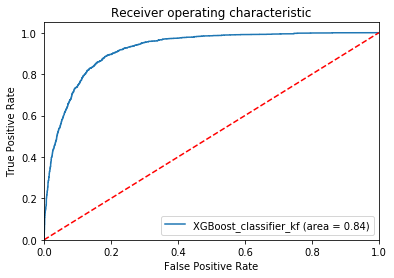

In [16]:
model_classifier(xgb_regressor,X,y,kf)

XGBoost using stratified k-fold cross validation

Accuracy scores of the model: 0.85

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3654
           1       0.87      0.82      0.84      3655

    accuracy                           0.85      7309
   macro avg       0.85      0.85      0.85      7309
weighted avg       0.85      0.85      0.85      7309


 Confusion Matrix of the model
--------------------------------------
[[3209  445]
 [ 656 2999]]

 ROC Curve


Enter your model name:  XGBoost_classifier_skf


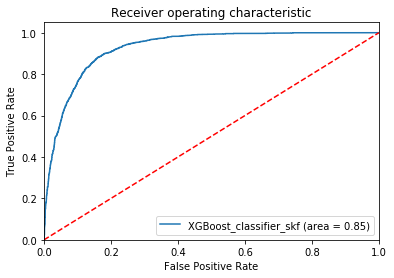

In [17]:
model_classifier(xgb_regressor,X,y,skf)

### XGBoost Hyperparameter tuning

In [25]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
xgb_hyp = XGBClassifier()

In [ ]:
xgb_random_search = RandomizedSearchCV(xgb_hyp, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=10, verbose=3)


In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_random_search.fit(X, y)
timer(start_time)

In [ ]:
xgb_random_search.best_estimator_

In [ ]:
xgb_random_search.best_params_

In [ ]:
xgb_tuned = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

model_classifier(xgb_tuned,X,y,skf)

### MLP
Definition - What does Multilayer Perceptron (MLP) mean?
A multilayer perceptron (MLP) is a feedforward artificial neural network that generates a set of outputs from a set of inputs. An MLP is characterized by several layers of input nodes connected as a directed graph between the input and output layers. MLP uses backpropogation for training the network. MLP is a deep learning method.

In [18]:
mlp = MLPClassifier()

MLP using K-fold cv

Accuracy scores of the model: 0.75

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.85      0.78      3636
           1       0.82      0.66      0.73      3673

    accuracy                           0.75      7309
   macro avg       0.76      0.75      0.75      7309
weighted avg       0.76      0.75      0.75      7309


 Confusion Matrix of the model
--------------------------------------
[[3097  539]
 [1257 2416]]

 ROC Curve


Enter your model name:  MLP_classifier_kf


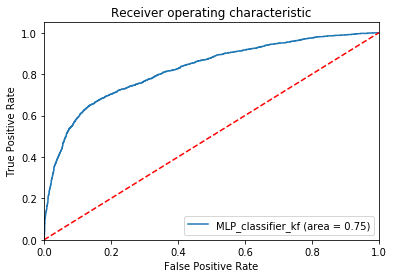

In [19]:
model_classifier(mlp,X,y,kf)

MLP using stratified k-fold cv

Accuracy scores of the model: 0.75

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3654
           1       0.81      0.66      0.73      3655

    accuracy                           0.76      7309
   macro avg       0.76      0.76      0.75      7309
weighted avg       0.76      0.76      0.75      7309


 Confusion Matrix of the model
--------------------------------------
[[3095  559]
 [1231 2424]]

 ROC Curve


Enter your model name:  MLP_Classifier_skf


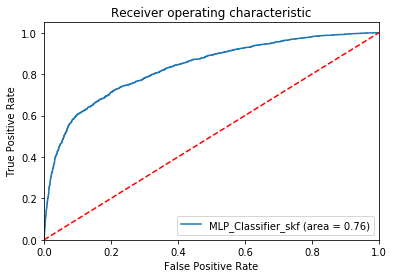

In [20]:
model_classifier(mlp,X,y,skf)

### Hyperparameter tuning for Multilayer perceptron

In [26]:
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_hyp = MLPClassifier()
randomized_mlp = RandomizedSearchCV(mlp_hyp, parameter_space, n_jobs=-1, cv=10)
start_time = timer(None) # timing starts from this point for "start_time" variable
randomized_mlp.fit(X, y)
timer(start_time) 


 Time taken: 5 hours 3 minutes and 3.4 seconds.


In [27]:
randomized_mlp.best_estimator_

MLPClassifier(alpha=0.05, hidden_layer_sizes=(20,), learning_rate='adaptive',
              solver='sgd')

In [28]:
randomized_mlp.best_params_

{'solver': 'sgd',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (20,),
 'alpha': 0.05,
 'activation': 'relu'}

Accuracy scores of the model: 0.74

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      3654
           1       0.79      0.66      0.72      3655

    accuracy                           0.74      7309
   macro avg       0.75      0.74      0.74      7309
weighted avg       0.75      0.74      0.74      7309


 Confusion Matrix of the model
--------------------------------------
[[3012  642]
 [1248 2407]]

 ROC Curve


Enter your model name:  mlp_tuned_skf


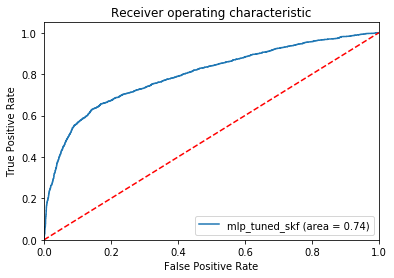

In [29]:
mlp_tuned = MLPClassifier(alpha=0.05, hidden_layer_sizes=(20,), learning_rate='adaptive',
              solver='sgd')
model_classifier(mlp_tuned,X,y,skf)

### Support Vector Machine Model;
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [50]:
from sklearn.svm import SVC
best_svr = SVR(kernel='rbf')

SVM using stratified k-fold cross validation

In [51]:
model_classifier(best_svr,X,y,skf)

ValueError: ignored

SVM using k-fold cross validation

In [ ]:
model_classifier(best_svr,X,y,kf)